# Importing libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import SGD, Adam, lr_scheduler
from copy import deepcopy
from torch.nn.init import xavier_uniform_ as xavier

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Utils

In [ ]:
def get_test_accuracy(model, best_model, test_loader):
    model.load_state_dict(best_model)
    size_test = len(test_loader.dataset)

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device)).cpu()
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {test_correct*100/size_test}%")
    return test_correct*100/size_test
            
def plot_accuracy(model, epochs = 2):
    plt.figure()
    plt.plot([i for i in range(epochs)], model.train_accuracy)
    plt.plot([i for i in range(epochs)], model.val_accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.title('Accuracy for train and test sets')
    plt.show()

def plot_loss(model, epochs = 2):
    plt.figure()
    plt.plot([i for i in range(epochs)], model.train_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss function value on training set during training')
    plt.show()

def xavier_weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
def load_data(random_seed = 0):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    train_transform = transforms.Compose([                                      
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

    test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

    train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(random_seed))

    train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2,
                                           worker_init_fn=seed_worker)

    val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                         shuffle=False, num_workers=2,
                                         worker_init_fn=seed_worker)

    test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2,
                                          worker_init_fn=seed_worker)
    
    return train_loader, val_loader, test_loader

In [ ]:
def train_cnn(cnn, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 2):
    best_accuracy = -1
    best_model = None
    model.train_loss = list()
    model.train_accuracy = list()
    model.val_accuracy = list()

    size_train = len(train_loader.dataset)
    size_val = len(val_loader.dataset)
    size_test = len(test_loader.dataset)

    for epoch in range(epochs):  

        model.train(True)
        training_loss = 0
        training_correct = 0

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs.detach(),dim=1)
            training_correct += (predicted == labels).sum().item()
    
        training_loss = training_loss/size_train
        training_accuracy = training_correct*100/size_train
    
        model.train_loss.append(training_loss)
        model.train_accuracy.append(training_accuracy)

        print(f"Epoch {epoch+1}")
        print(f"Training loss: {training_loss}")
        print(f"Training accuracy: {training_accuracy}%")    

        validation_correct = 0
        model.train(False)
        with torch.no_grad():
            for inputs,labels in val_loader:
                outputs = model(inputs.cuda()).cpu()
                predicted = torch.argmax(outputs.detach(), dim=1)
                validation_correct += (predicted == labels).sum().item()

        val_accuracy = validation_correct*100/size_val
        model.val_accuracy.append(val_accuracy)

        print(f"Validation accuracy: {val_accuracy}%")

        if validation_correct > best_accuracy:
            best_accuracy = validation_correct
            best_model = deepcopy(model.state_dict())

        # test_correct = 0
        # with torch.no_grad():
        #     for inputs, labels in test_loader:
        #         outputs = model(inputs.cuda()).cpu()
        #         predicted = torch.argmax(outputs, dim=1)
        #         test_correct += (predicted == labels).sum().item()

        # print(f"Test accuracy: {test_correct*100/size_test}%")

        scheduler.step()
        print('-'*30)

    print('Finished Training')
    return best_model

# VGG pretrained on ImageNet, only last layer changed, Adam optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 10))

        # freeze weights of all the models
        for param in pretrained_model.parameters():
            param.requires_grad = False
        # unfreeze the last layer so it can be trained
        for param in pretrained_model.classifier[6].parameters():
            param.requires_grad = True

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
train_loader, val_loader, test_loader = load_data(0)
model = VGG16CNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.8305161094029745
Training accuracy: 70.9888888888889%
Validation accuracy: 77.32%
Test accuracy: 77.87%
------------------------------
Epoch 2
Training loss: 0.7109052604251438
Training accuracy: 75.00444444444445%
Validation accuracy: 78.78%
Test accuracy: 78.66%
------------------------------
Epoch 3
Training loss: 0.6909681445121765
Training accuracy: 75.74%
Validation accuracy: 79.08%
Test accuracy: 78.84%
------------------------------
Epoch 4
Training loss: 0.692745089424981
Training accuracy: 75.66%
Validation accuracy: 79.02%
Test accuracy: 78.9%
------------------------------
Epoch 5
Training loss: 0.6905946236292522
Training accuracy: 75.9888888888889%
Validation accuracy: 79.02%
Test accuracy: 78.91%
------------------------------
Finished Training


In [ ]:
get_test_accuracy(model, best_model, test_loader)

Test accuracy: 78.84%


78.84

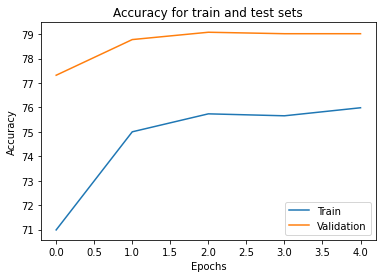

In [ ]:
plot_accuracy(model, epochs = 5)

In [ ]:
test_acc = [78.84]
for i in range(1, 3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 5)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



Epoch 1
Training loss: 0.8355748741785686
Training accuracy: 70.89333333333333%
Validation accuracy: 77.86%
Test accuracy: 77.16%
------------------------------
Epoch 2
Training loss: 0.7128859334309896
Training accuracy: 75.03111111111112%
Validation accuracy: 79.4%
Test accuracy: 78.44%
------------------------------
Epoch 3
Training loss: 0.6976245868894789
Training accuracy: 75.48%
Validation accuracy: 79.64%
Test accuracy: 78.51%
------------------------------
Epoch 4
Training loss: 0.693813654200236
Training accuracy: 75.58222222222223%
Validation accuracy: 79.58%
Test accuracy: 78.56%
------------------------------
Epoch 5
Training loss: 0.6975862715615166
Training accuracy: 75.59333333333333%
Validation accuracy: 79.58%
Test accuracy: 78.58%
------------------------------
Finished Training
Test accuracy: 78.51%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.8332910938051011
Training accuracy: 70.9088888888889%
Validation ac

In [ ]:
print(np.mean(test_acc))

78.64
78.64


# VGG pretrained on ImageNet, all classification layers changed, Adam optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.7800726302040948
Training accuracy: 74.15555555555555%
Validation accuracy: 80.78%
------------------------------
Epoch 2
Training loss: 0.32613031949996946
Training accuracy: 88.99333333333334%
Validation accuracy: 85.02%
------------------------------
Epoch 3
Training loss: 0.22820178083843656
Training accuracy: 92.34444444444445%
Validation accuracy: 85.18%
------------------------------
Finished Training
Test accuracy: 85.64%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.7834172583262126
Training accuracy: 74.00888888888889%
Validation accuracy: 83.66%
------------------------------
Epoch 2
Training loss: 0.32637091528574624
Training accuracy: 89.1%
Validation accuracy: 86.3%
------------------------------
Epoch 3
Training loss: 0.2286855621125963
Training accuracy: 92.21555555555555%
Validation accuracy: 86.24%
----------------

In [ ]:
print(np.mean(test_acc))

85.49333333333334


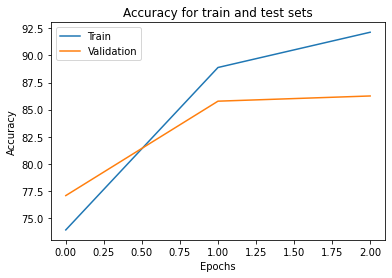

In [ ]:
plot_accuracy(model, epochs=3)

# VGG without batch normalisation, all classification layers changed, Adam optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch 1
Training loss: 0.7173138912147946
Training accuracy: 77.42444444444445%
Validation accuracy: 85.78%
------------------------------
Epoch 2
Training loss: 0.2979366521437963
Training accuracy: 90.12666666666667%
Validation accuracy: 88.5%
------------------------------
Epoch 3
Training loss: 0.21550468161900838
Training accuracy: 92.88222222222223%
Validation accuracy: 88.7%
------------------------------
Finished Training
Test accuracy: 88.23%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.7168943653530545
Training accuracy: 77.38%
Validation accuracy: 83.66%
------------------------------
Epoch 2
Training loss: 0.3148150984976027
Training accuracy: 89.58%
Validation accuracy: 87.92%
------------------------------
Epoch 3
Training loss: 0.2225900661892361
Training accuracy: 92.56222222222222%
Validation accuracy: 88.36%
------------------------------
Finished Training
Test accuracy: 88.06%
Files already downloaded and verif

In [ ]:
print(np.mean([88.23, 88.06, 87.78]))

88.02333333333335


In [ ]:
plot_accuracy(model, epochs=3)

# VGG without batch normalization, all layers changed, Adam optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch 1
Training loss: 2.31262536438836
Training accuracy: 9.782222222222222%
Validation accuracy: 9.88%
------------------------------
Epoch 2
Training loss: 2.303683336724175
Training accuracy: 9.893333333333333%
Validation accuracy: 10.04%
------------------------------
Epoch 3
Training loss: 2.303371834903293
Training accuracy: 9.846666666666666%
Validation accuracy: 9.34%
------------------------------
Finished Training
Test accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.8428346403757732
Training accuracy: 30.413333333333334%
Validation accuracy: 39.58%
------------------------------
Epoch 2
Training loss: 1.343764072863261
Training accuracy: 50.48%
Validation accuracy: 57.28%
------------------------------
Epoch 3
Training loss: 1.1277360424889458
Training accuracy: 59.15777777777778%
Validation accuracy: 59.56%
------------------------------
Finished Training
Test accuracy: 58.54%
Files already downloaded and

In [ ]:
print(np.mean(test_acc))

43.71


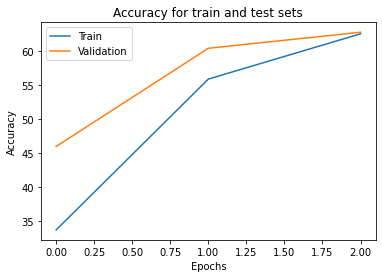

In [ ]:
plot_accuracy(model, epochs=3)

# VGG pretrained on ImageNet, only last layer changed, SGD optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 10))

        # freeze weights of all the models
        for param in pretrained_model.parameters():
            param.requires_grad = False
        # unfreeze the last layer so it can be trained
        for param in pretrained_model.classifier[6].parameters():
            param.requires_grad = True

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 5)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



Epoch 1
Training loss: 1.5948932282129924
Training accuracy: 54.72888888888889%
Validation accuracy: 70.16%
------------------------------
Epoch 2
Training loss: 1.2017885462443034
Training accuracy: 66.82444444444444%
Validation accuracy: 70.56%
------------------------------
Epoch 3
Training loss: 1.183543518087599
Training accuracy: 67.3488888888889%
Validation accuracy: 70.54%
------------------------------
Epoch 4
Training loss: 1.1824314615461562
Training accuracy: 67.34666666666666%
Validation accuracy: 70.56%
------------------------------
Epoch 5
Training loss: 1.1822052436404757
Training accuracy: 67.15555555555555%
Validation accuracy: 70.56%
------------------------------
Finished Training
Test accuracy: 71.66%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.596273055521647
Training accuracy: 54.684444444444445%
Validation accuracy: 71.38%
------------------------------
Epoch 2
Training loss: 1.2054432658089531
Training 

In [ ]:
print(np.mean(test_acc))

71.29


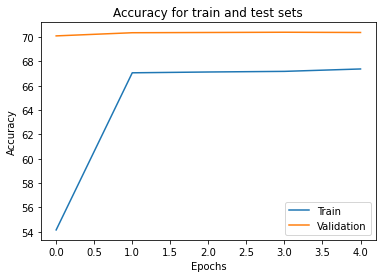

In [ ]:
plot_accuracy(model, epochs=5)

# VGG pretrained on ImageNet, all classification layers changed, SGD optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.4918576480229695
Training accuracy: 56.13333333333333%
Validation accuracy: 71.86%
------------------------------
Epoch 2
Training loss: 1.0279060356034173
Training accuracy: 68.4088888888889%
Validation accuracy: 72.26%
------------------------------
Epoch 3
Training loss: 1.007530436261495
Training accuracy: 69.0911111111111%
Validation accuracy: 72.36%
------------------------------
Finished Training
Test accuracy: 73.24%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.494321931584676
Training accuracy: 56.14666666666667%
Validation accuracy: 72.46%
------------------------------
Epoch 2
Training loss: 1.0321556302176582
Training accuracy: 68.30888888888889%
Validation accuracy: 73.32%
------------------------------
Epoch 3
Training loss: 1.0141896556218466
Training accuracy: 68.69555555555556%
Validation accuracy: 73.34%
---------

In [ ]:
print(np.mean(test_acc))

72.92


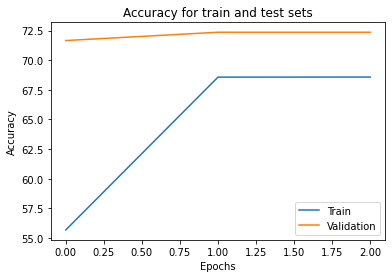

In [ ]:
plot_accuracy(model, epochs=3)

# VGG without batch normalization, all classification layers changed, SGD optimizer


In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.102358359951443
Training accuracy: 65.26%
Validation accuracy: 78.76%
------------------------------
Epoch 2
Training loss: 0.7225641087638007
Training accuracy: 75.7%
Validation accuracy: 79.76%
------------------------------
Epoch 3
Training loss: 0.7121496701558431
Training accuracy: 75.94666666666667%
Validation accuracy: 79.76%
------------------------------
Finished Training
Test accuracy: 78.89%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 1.0978964070002237
Training accuracy: 65.29333333333334%
Validation accuracy: 78.6%
------------------------------
Epoch 2
Training loss: 0.7266609089533488
Training accuracy: 75.44%
Validation accuracy: 79.46%
------------------------------
Epoch 3
Training loss: 0.7157019476148817
Training accuracy: 75.65555555555555%
Validation accuracy: 79.6%
------------------------------
Finished Train

In [ ]:
print(np.mean(test_acc))

78.8


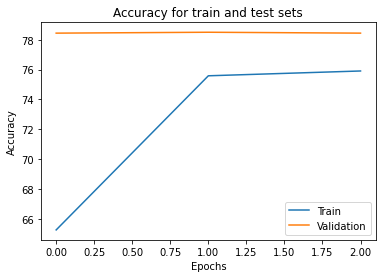

In [ ]:
plot_accuracy(model, epochs=3)

# VGG without batch normalization, all layers changed, SGD optimizer

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

In [ ]:
print(np.mean(test_acc))

In [ ]:
plot_accuracy(model, epochs=3)